In [3]:
import os
import json
from datetime import datetime

from torchvision.models import vit_b_16, vit_l_16
import torch
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models

import seaborn as sns
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
simple_load = v2.Compose([
    v2.Resize((224, 224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
])

In [6]:
data_8cls_base_path = 'data/processed8'
data_2cls_base_path = 'data/processed2'
# data_8cls_base_path = 'data/subset'
# data_2cls_base_path = 'data/subset'

In [7]:
train_dataset_8cls = ImageFolder(f'{data_8cls_base_path}/train/known', transform=simple_load)
test_dataset_8cls = ImageFolder(f'{data_8cls_base_path}/test/known', transform=simple_load)
val_dataset_8cls = ImageFolder(f'{data_8cls_base_path}/valid/known', transform=simple_load)

train_dataset_2cls = ImageFolder(f'{data_2cls_base_path}/train/known', transform=simple_load)
test_dataset_2cls = ImageFolder(f'{data_2cls_base_path}/test/known', transform=simple_load)
val_dataset_2cls = ImageFolder(f'{data_2cls_base_path}/valid/known', transform=simple_load)

In [8]:
def get_image(path: str):
    image = torchvision.io.read_image(path)
    return v2.ToPILImage()(image)


def get_image_resized(path: str):
    image = get_image(path)
    # Resize required for ViT to work. It is done for all models for a fair comparison
    resize = v2.Resize((224, 224))
    bigger_image = resize(image)

    return v2.ToPILImage()(bigger_image)

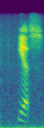

In [11]:
path = f'./{data_8cls_base_path}/train/known/yes/004ae714_nohash_0.png'
get_image(path)

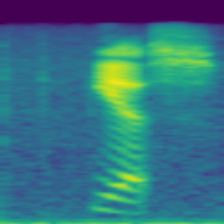

In [12]:
get_image_resized(path)

## Models

CNN Model Resnet-18 not pretrained (random weights)

In [8]:
def get_resnet(n_classes: int):
    model_resnet = models.resnet18(pretrained=False)

    output_features = model_resnet.fc.in_features 
    ## We have 512 output features, we have to add to model a fully connected layer for our 
    ## classification problem with only specified target classes
    model_resnet.fc = nn.Linear(output_features, n_classes)
    model_resnet = model_resnet.to(device)
    return model_resnet

Custom CRNN

In [13]:
class CustomCRNN(nn.Module):

    def __init__(self, n_classes: int):
        super(CustomCRNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()
        self.rnn = nn.LSTM(input_size=128 * 6 * 6, hidden_size=256)
        self.softmax = nn.Sequential(
            nn.Linear(256, n_classes),
            nn.Softmax(dim=1),
        )
        self.to(device)

    def forward(self, obs) -> torch.Tensor:
        out_conv = self.conv(obs)
        out_conv_flat = self.flatten(out_conv)
        out_rnn = self.rnn(out_conv_flat)[0]
        out_proba = self.softmax(out_rnn)
        return out_proba

Transformer VIT-base-16

In [10]:
def get_vit_base():
    vit_base = vit_b_16()
    vit_base.to(device)
    return vit_base

Transformer VIT-large-16

In [11]:
def get_vit_large():
    vit_large = vit_l_16()
    vit_large.to(device)
    return vit_large

## Train function

In [14]:
def train(network: nn.Module, train_dataset: ImageFolder, valid_dataset: ImageFolder, batch_size: int,
          loss_fn, optimizer: torch.optim.Optimizer, max_epochs: int,
          save_name: str | None = None, verbosity_period=1) -> dict[str, list[float]]:
    """
    Based on: https://alirezasamar.com/blog/2023/03/fine-tuning-pre-trained-resnet-18-model-image-classification-pytorch/

    Returns:
        training statstics
    """
    train_loss_per_epoch: list[float] = []
    train_accuracy_per_epoch: list[float] = []
    valid_loss_per_epoch: list[float] = []
    valid_accuracy_per_epoch: list[float] = []

    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(max_epochs):
        epoch = epoch + 1

        # setup for training
        network.train()
        train_epoch_loss_sum = 0.0
        train_epoch_true_count = 0

        # training loop
        for images, true_labels in train_data_loader:

            # move to the device (especially necessary when using cuda)
            images = images.to(device)
            true_labels = true_labels.to(device)

            # feed forward
            optimizer.zero_grad()
            pred_proba = network(images)

            loss = loss_fn(pred_proba, true_labels)
            # backpropagation and update weights
            loss.backward()
            optimizer.step()

            # update current epoch's stats
            train_epoch_loss_sum += loss.item() * images.size(0)
            # calculate accuracy but only if no advanced augmentations are used
            # this is because with advanced augmentations true_labels becomes
            # probabilites of each class
            pred_labels = torch.argmax(pred_proba, dim=1)
            train_epoch_true_count += torch.sum(pred_labels == true_labels.data)

        # calculate and update stats
        curr_train_loss = float(train_epoch_loss_sum / len(train_dataset))
        train_loss_per_epoch.append(curr_train_loss)
        curr_train_accuracy = float(train_epoch_true_count.double() / len(train_dataset))
        train_accuracy_per_epoch.append(curr_train_accuracy)

        # setup for validation
        network.eval()
        valid_epoch_loss_sum = 0.0
        valid_epoch_true_count = 0

        with torch.no_grad():
            # same as before but on validation data
            for images, true_labels in valid_data_loader:
                # move to device
                images = images.to(device)
                true_labels = true_labels.to(device)

                # make a prediction
                pred_proba = network(images)
                pred_labels = torch.argmax(pred_proba, dim=1)
                loss = loss_fn(pred_proba, true_labels)

                # update stats
                valid_epoch_loss_sum += loss.item() * images.size(0)
                valid_epoch_true_count += torch.sum(pred_labels == true_labels.data)

        # calculate and update stats
        curr_valid_loss = float(valid_epoch_loss_sum / len(val_dataset_8cls))
        curr_valid_acccuracy = float(valid_epoch_true_count.double() / len(val_dataset_8cls))
        valid_loss_per_epoch.append(curr_valid_loss)
        valid_accuracy_per_epoch.append(curr_valid_acccuracy)

        # Verbosity
        if  verbosity_period > 0 and epoch % verbosity_period == 0:
            train_acc_text = ''
            train_acc_text = f'Train accuracy: {curr_train_accuracy:.4f} | '
            print(f'Epoch {epoch} completed! | '
                  f'Train loss: {curr_train_loss:.4f} | '
                  f'{train_acc_text}'
                  f'Validation loss: {curr_valid_loss:.4f} | '
                  f'Validation accuracy: {curr_valid_acccuracy:.4f}')

    stats = {
        'train_loss': train_loss_per_epoch,
        'train_accuracy': train_accuracy_per_epoch,
        'valid_loss': valid_loss_per_epoch,
        'valid_accuracy': valid_accuracy_per_epoch,
    }

    # save network weights and stats at the end
    if save_name is not None:
        # prepare save dir
        datetime_id = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
        save_dir = os.path.join('.', 'saved', f'{save_name}_{datetime_id}')
        os.makedirs(save_dir, exist_ok=True)
        # save network weights
        model_path = os.path.join(save_dir, f'{save_name}.pth')
        torch.save(network.state_dict(), model_path)
        # save training stats
        stats_path = os.path.join(save_dir, f'{save_name}.json')
        with open(stats_path, 'w') as file:
            json.dump(stats, file)
    
    return stats

In [15]:
def load_weights(network_fresh: nn.Module, path: str) -> None:
    """Loads saved weights to the given network"""
    network_fresh.load_state_dict(torch.load(path, map_location=torch.device(device)))
    network_fresh.eval()

In [16]:
def load_stats(path: str) -> dict[str, list[float]]:
    with open(path) as file:
        stats = json.load(file)
    return stats

# Train models

### Train Resnet-18 not pretrained

In [21]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

model_resnet = get_resnet(8)

stats_resnet = train(
    model_resnet, train_dataset_8cls, val_dataset_8cls, 
    batch_size=64, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(model_resnet.parameters(), lr=0.001), 
    max_epochs=15,
    save_name='architectures_resnet',
)

Epoch 1 completed! | Train loss: 0.4077 | Train accuracy: 0.8625 | Validation loss: 1.6580 | Validation accuracy: 0.5761
Epoch 2 completed! | Train loss: 0.1520 | Train accuracy: 0.9486 | Validation loss: 0.1973 | Validation accuracy: 0.9305
Epoch 3 completed! | Train loss: 0.1167 | Train accuracy: 0.9623 | Validation loss: 0.2974 | Validation accuracy: 0.9005
Epoch 4 completed! | Train loss: 0.0963 | Train accuracy: 0.9680 | Validation loss: 0.1516 | Validation accuracy: 0.9454
Epoch 5 completed! | Train loss: 0.0843 | Train accuracy: 0.9701 | Validation loss: 0.1597 | Validation accuracy: 0.9488
Epoch 6 completed! | Train loss: 0.0646 | Train accuracy: 0.9777 | Validation loss: 0.1910 | Validation accuracy: 0.9305
Epoch 7 completed! | Train loss: 0.0751 | Train accuracy: 0.9747 | Validation loss: 0.1250 | Validation accuracy: 0.9623
Epoch 8 completed! | Train loss: 0.0476 | Train accuracy: 0.9835 | Validation loss: 0.1048 | Validation accuracy: 0.9696
Epoch 9 completed! | Train loss:

### Custom CRNN

In [17]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

model_crnn = CustomCRNN(8)

stats_crnn = train(
    model_crnn, train_dataset_8cls, val_dataset_8cls, 
    batch_size=64, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(model_crnn.parameters(), lr=0.001), 
    max_epochs=50,
    save_name='architectures_crnn'
)

torch.Size([64, 128, 6, 6])
torch.Size([64, 128, 6, 6])


KeyboardInterrupt: 

### Train vit base

In [15]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

vit_base = get_vit_base()

stats_vit_base = train(
    vit_base, train_dataset_8cls, val_dataset_8cls, 
    batch_size=32, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(vit_base.parameters(), lr=0.001), 
    max_epochs=25,
    save_name='architectures_vit_base',
)

Epoch 1 completed! | Train loss: 2.1413 | Train accuracy: 0.1267 | Validation loss: 2.0881 | Validation accuracy: 0.1304
Epoch 2 completed! | Train loss: 2.0883 | Train accuracy: 0.1322 | Validation loss: 2.0689 | Validation accuracy: 0.1719
Epoch 3 completed! | Train loss: 2.0864 | Train accuracy: 0.1346 | Validation loss: 2.0833 | Validation accuracy: 0.1193
Epoch 4 completed! | Train loss: 2.0940 | Train accuracy: 0.1302 | Validation loss: 2.0834 | Validation accuracy: 0.1193
Epoch 5 completed! | Train loss: 2.0859 | Train accuracy: 0.1253 | Validation loss: 2.0825 | Validation accuracy: 0.1236
Epoch 6 completed! | Train loss: 2.0852 | Train accuracy: 0.1267 | Validation loss: 2.0789 | Validation accuracy: 0.1275
Epoch 7 completed! | Train loss: 2.0753 | Train accuracy: 0.1489 | Validation loss: 2.1031 | Validation accuracy: 0.1304
Epoch 8 completed! | Train loss: 2.0848 | Train accuracy: 0.1233 | Validation loss: 2.0850 | Validation accuracy: 0.1241
Epoch 9 completed! | Train loss:

### Train vit large

Due to very long training times, we have decided to train the large version of ViT only on 2 classes.

In [15]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

vit_large = get_vit_large()

stats_vit_base = train(
    vit_large, train_dataset_2cls, val_dataset_2cls, 
    batch_size=16, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.Adam(vit_large.parameters(), lr=0.001), 
    max_epochs=5,
    save_name='architectures_vit_large',
)

Epoch 1 completed! | Train loss: 2.1366 | Train accuracy: 0.1272 | Validation loss: 2.0833 | Validation accuracy: 0.1241
Epoch 2 completed! | Train loss: 2.0935 | Train accuracy: 0.1273 | Validation loss: 2.0929 | Validation accuracy: 0.1236
Epoch 3 completed! | Train loss: 2.0914 | Train accuracy: 0.1246 | Validation loss: 2.0835 | Validation accuracy: 0.1260


KeyboardInterrupt: 

# Hyperparameters

In [41]:
from typing import Any
from bayes_opt import BayesianOptimization

In [42]:
def save_bayes_result(path: str, best_params: dict[str, Any], best_accuracy: float):
    data = {
        'best_params': best_params,
        'best_accuracy': best_accuracy,
    }
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'w') as file:
        json.dump(data, file)


def load_bayes_result(path: str) -> tuple[dict[str, Any], float]:
    with open(path, 'r') as file:
        data = json.load(file)
    return data['best_params'], data['best_accuracy']

### ResNet-18

In [44]:
def objective_function_resnet_adam(batch_size_exp, learning_rate, l2_reg, beta1, beta2):
    batch_size = 2**int(batch_size_exp)
    model = get_resnet(2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg, betas=(beta1, beta2))

    stats = train(model, train_dataset_8cls, val_dataset_8cls, batch_size, criterion, optimizer, max_epochs=15, verbosity_period=0)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [45]:
pbounds = {
    'batch_size_exp': (5, 10),  # will be rounded down so from 5 to 9, making batch size from 32 to 512
    'learning_rate': (1e-4, 0.01),
    'l2_reg': (1e-5, 0.01),
    'beta1': (0.0, 0.99),
    'beta2': (0.0, 0.99)
    
}
optimizer = BayesianOptimization(
    f=objective_function_resnet_adam,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=2,
    n_iter=2
)
best_hyperparams_resnet_adam = optimizer.max['params']
accuracy_resnet_adam = optimizer.max['target']
save_bayes_result('./saved/bayes/resnet_adam.json', best_hyperparams_resnet_adam, accuracy_resnet_adam)

|   iter    |  target   | batch_... |   beta1   |   beta2   |  l2_reg   | learni... |
-------------------------------------------------------------------------------------
| 1         | 1.0       | 6.873     | 0.9412    | 0.7247    | 0.005991  | 0.001645  |
| 2         | 1.0       | 5.78      | 0.0575    | 0.8575    | 0.006015  | 0.00711   |
| 3         | 1.0       | 9.975     | 0.9284    | 0.004239  | 0.008856  | 0.0007583 |
| 4         | 1.0       | 5.0       | 0.1352    | 0.0367    | 0.001638  | 0.007109  |


### CRNN

In [53]:
def objective_function_customcrnn_adam(batch_size_exp, learning_rate, l2_reg, beta1, beta2):
    batch_size = 2**int(batch_size_exp)
    model = CustomCRNN(8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg, betas=(beta1, beta2))

    stats = train(model, train_dataset_8cls, val_dataset_8cls, batch_size, criterion, optimizer, max_epochs=15, verbosity_period=0)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [54]:
pbounds = {
    'batch_size_exp': (5, 10),  # will be rounded down so from 5 to 9, making batch size from 32 to 512
    'learning_rate': (1e-4, 0.01),
    'l2_reg': (1e-5, 0.01),
    'beta1': (0.0, 0.99),
    'beta2': (0.0, 0.99)
}
optimizer = BayesianOptimization(
    f=objective_function_customcrnn_adam,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=1,
    n_iter=2
)
best_hyperparams_customcrnn = optimizer.max['params']
accuracy_customcrnn = optimizer.max['target']
save_bayes_result('./saved/bayes/customcrnn_adam.json', best_hyperparams_customcrnn, accuracy_customcrnn)

|   iter    |  target   | batch_... |   beta1   |   beta2   |  l2_reg   | learni... |
-------------------------------------------------------------------------------------
| 1         | 1.0       | 6.873     | 0.9412    | 0.7247    | 0.005991  | 0.001645  |
| 2         | 1.0       | 10.0      | 0.0       | 0.0       | 1e-05     | 0.01      |
| 3         | 1.0       | 5.009     | 0.9304    | 0.9388    | 0.007107  | 0.00429   |


### Transformer VIT-base-16

In [56]:
def objective_function_vit_base_adam(batch_size_exp, learning_rate, l2_reg, beta1, beta2):
    batch_size = 2**int(batch_size_exp)
    model = get_vit_base()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg, betas=(beta1, beta2))

    stats = train(model, train_dataset_8cls, val_dataset_8cls, batch_size, criterion, optimizer, max_epochs=15, verbosity_period=0)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [57]:
pbounds = {
    'batch_size_exp': (5, 10),  # will be rounded down so from 5 to 9, making batch size from 32 to 512
    'learning_rate': (1e-4, 0.01),
    'l2_reg': (1e-5, 0.01),
    'beta1': (0.0, 0.99),
    'beta2': (0.0, 0.99)
    
}
optimizer = BayesianOptimization(
    f=objective_function_vit_base_adam,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=1,
    n_iter=2
)
best_hyperparams_vit_base_adam = optimizer.max['params']
accuracy_vit_base_adam = optimizer.max['target']
save_bayes_result('./saved/bayes/vit_base_adam.json', best_hyperparams_vit_base_adam, accuracy_vit_base_adam)

|   iter    |  target   | batch_... |   beta1   |   beta2   |  l2_reg   | learni... |
-------------------------------------------------------------------------------------
| 1         | 1.0       | 6.873     | 0.9412    | 0.7247    | 0.005991  | 0.001645  |
| 2         | 1.0       | 10.0      | 0.0       | 0.0       | 1e-05     | 0.01      |
| 3         | 1.0       | 5.009     | 0.9304    | 0.9388    | 0.007107  | 0.00429   |


### Transformer VIT-large-16

In [59]:
def objective_function_vit_large_adam(batch_size_exp, learning_rate, l2_reg, beta1, beta2):
    batch_size = 2**int(batch_size_exp)
    model = get_vit_large()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg, betas=(beta1, beta2))

    stats = train(model, train_dataset_2cls, val_dataset_2cls, batch_size, criterion, optimizer, max_epochs=15, verbosity_period=0)
    val_acc = stats['valid_accuracy'][-1]
    return val_acc

In [ ]:
pbounds = {
    'batch_size_exp': (5, 10),  # will be rounded down so from 5 to 9, making batch size from 32 to 512
    'learning_rate': (1e-4, 0.01),
    'l2_reg': (1e-5, 0.01),
    'beta1': (0.0, 0.99),
    'beta2': (0.0, 0.99)
    
}
optimizer = BayesianOptimization(
    f=objective_function_vit_large_adam,
    pbounds=pbounds,
    random_state=42
)
optimizer.maximize(
    init_points=0,
    n_iter=1
)
best_hyperparams_vit_large_adam = optimizer.max['params']
accuracy_vit_large_adam = optimizer.max['target']
save_bayes_result('./saved/bayes/vit_large_adam.json', best_hyperparams_vit_large_adam, accuracy_vit_large_adam)

## Result evaluation

In [16]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

def calculate_confusion_matrix(predictor: nn.Module, dataset: torch.Tensor, n_classes: int, verbose=True):
    """
    Returns:
        Confusion matrix, total accuracy, accuracy per class
    """
    batch_size = 1000
    photos_processed = 0
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    predictor.eval()

    confusion_matrix = torch.zeros(n_classes, n_classes)
    true_counts_per_class = torch.zeros(n_classes)
    class_counts = torch.zeros(n_classes)

    with torch.no_grad():
        for images, true_labels in data_loader:
            images = images.to(device)
            true_labels = true_labels.to(device)
            pred = predictor(images)
            if len(pred.shape) == 2:
                pred = torch.argmax(pred, dim=1)

            for true_label, pred_label in zip(true_labels, pred):
                confusion_matrix[true_label, pred_label] += 1
                class_counts[true_label] += 1
                if true_label == pred_label:
                    true_counts_per_class[true_label] += 1

            if verbose:
                photos_processed += batch_size
                print(f'processed {photos_processed} photos')

    accuracy_per_class = (true_counts_per_class / class_counts).tolist()
    accuracy_total = float(true_counts_per_class.sum() / class_counts.sum())

    return confusion_matrix, accuracy_total, accuracy_per_class

In [17]:
matrix_resnet, acc_total_resnet, acc_per_class_resnet = calculate_confusion_matrix(model_resnet, train_dataset_8cls, n_classes=8)

NameError: name 'model_resnet' is not defined

In [ ]:
matrix_crnn, acc_total_crnn, acc_per_class_crnn = calculate_confusion_matrix(model_crnn, train_dataset_8cls, n_classes=8)

In [116]:
matrix_vit_base, acc_total_vit_base, acc_per_class_vit_base = calculate_confusion_matrix(vit_base, train_dataset_8cls, n_classes=8)

processed 1000 photos


In [ ]:
matrix_vit_large, acc_total_vit_large, acc_per_class_vit_large = calculate_confusion_matrix(vit_large, train_dataset_8cls, n_classes=8)

# Silence and Unknown detection